In [6]:
import os
import csv
import numpy as np

class Result:
    
    def __init__(self, name, age):
        self.name = name
        self.counts = dict()
        self.snp_sums = dict()
        self.age = age
        self.snps = dict()
        
    def set_count(self, kmer_name, count):
        self.counts[kmer_name] = count
        
    def normalized_tel(self):
        sum_all = (sum(self.counts.values())-self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT'])/3000
        return (self.tel_count()/sum_all)
    
    def tel_count(self):
        return self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']
        
    def get_label(self):
        return "{}:{}, {}".format(self.name[7:], 
                              int(self.counts['GAGTCAAAAGCAGATACGTGTGTCA']), int(self.counts['GAGTCAAAAGCAGATACATGTGTCA']))
        
    def __str__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def __repr__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def get_snp_vals(self):
        result = list()
        for k,s in self.snps.iteritems():
            if s['main']:
                result.append(s['main'])
            else:
                result.append(s['minor'])
        return result
        
    
    def get_input(self):
        output = list()
        output.append(self.normalized_tel())
        #output.append(self.age)
        #output.append(self.age)
        rss = ['rs621559',
            'rs11125529',
            'rs4452212',
            'rs16859140',
            'rs12696304',
            'rs10936599',
            'rs1317082',
            'rs10936601',
            'rs7680468',
            'rs2736100',
            'rs2098713',
            'rs2736428',
            'rs654128',
            'rs34596385',
            'rs11787341',
            'rs10904887',
            'rs10466239',
            'rs9419958',
            'rs9420907',
            'rs4387287',
            'rs17653722',
            'rs398652',
            'rs4902100',
            'rs74019828',
            'rs3027234',
            'rs2162440',
            'rs412658',
            'rs1975174',
            'rs6028466',
            'rs73394838']
        for r in rss:
            if r in self.snps:
                output.append(1 if bool(self.snps[r]['minor']) else -1)
        
        #output = output+snps
        return output
    
    def calculate_snps(self):
        with open ('./static/snp_kmers.txt') as f:
            reader = csv.reader(f, delimiter='\t')
            for row in reader:
                name = row[0]
                alt = False
                if name[0:4] == 'ALT_':
                    name = name[4:].split(':')[0]
                    alt = True
                else:
                    name = name.split(':')[0]
                
                if name not in self.snps:
                    self.snps[name] = dict()
                    self.snps[name]['main'] = 0
                    self.snps[name]['minor'] = 0
                    
                count = int(self.counts[row[1].strip()])
                    
                if alt:
                    self.snps[name]['minor'] += count
                else:
                    self.snps[name]['main'] += count
            f.close()
                    

                    
print "Starting..."
        
ages = dict()
with open('./static/SraRunTable.txt') as run_table:
    r = csv.reader(run_table, delimiter='\t')
    r.next()
    for row in r:
        ages[row[8]] = row[11]
        
def get_age(name):
    return int(ages[name])

def status():
    tot_m, used_m, free_m = map(str, os.popen('free -t -h').readlines()[-1].split()[1:])
    print used_m
    


print "Runtable OK!"
    
results = list()
k=1
for file in os.listdir('./files'):
    name = file[:-4]
    try:
        age = get_age(name)
    except:
        continue
    result = Result(name, age)
    with open('./files/'+file) as f:
        reader = csv.reader(f, delimiter='\t')  
        for row in reader:
            result.set_count(row[0], float(row[1]))
    result.calculate_snps()
    results.append(result)
    f.close()
    k += 1
    if k%1000==0:
        status()
        #break
print "OK!"

Starting...
Runtable OK!
1.0G
1.2G
1.7G
2.1G
2.5G
3.0G
3.4G
3.9G
4.3G
4.7G
5.2G
OK!


<IPython.core.display.Javascript object>


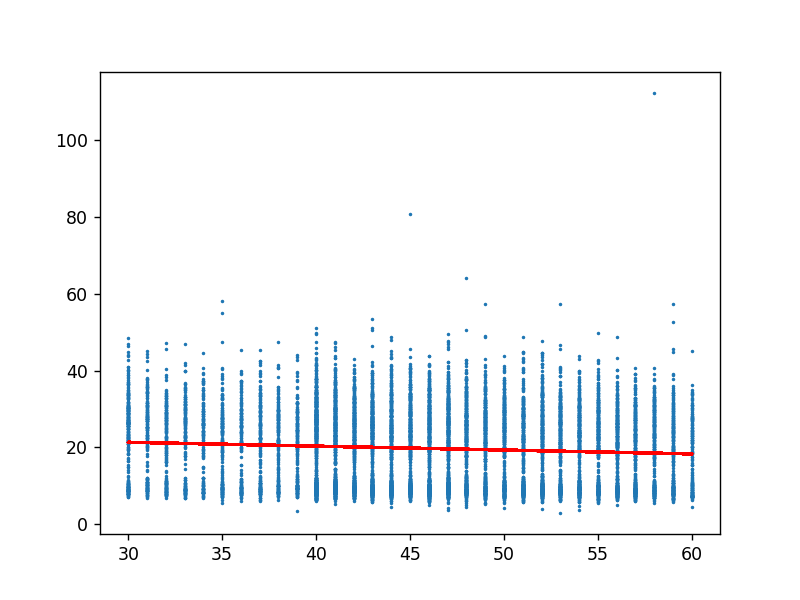

y=-0.101003x+(24.388346)


In [11]:
%matplotlib nbagg

import matplotlib.pyplot as plt

x = list(map(lambda r: r.age, results))
y = list(map(lambda r: r.normalized_tel(), results))
labels = list(map(lambda r: r.get_label(), results))
plt.scatter(x, y, s=1)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

for label, x, y in zip(labels, x,y):
    break
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()
print "y=%.6fx+(%.6f)"%(z[0],z[1])

In [8]:
print "tes2tt"

tes2tt


In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Embedding, Input, Conv2D,MaxPooling1D, LSTM,SimpleRNN,Reshape
from keras.layers.convolutional import Conv1D
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical,normalize
import random

d = 31

dummy_w = np.random.rand(d,2)
#print dummy_w

def get_dummy_input(r):
    output = list()
    
    a_input = 0
    for c in range(0,d):
        choice = 1 if bool(random.getrandbits(1)) else 0
        a_input += r.age*dummy_w[c][choice]
        output.append(1 if choice else -1)
        
        
    output.append(a_input)
    
    return output


#inputs = list(map(lambda r: get_dummy_input(r), results))
inputs = list(map(lambda r: r.get_input(), results))
outputs = list(map(lambda r: r.age, results))

inputs = np.array(inputs)
outputs = np.array(outputs)

print inputs[0]
print outputs[0]


model = Sequential()
a = inputs.shape[1]

print inputs[0].shape

model.add(Dense(inputs[0].shape[0],kernel_initializer="uniform", input_shape=inputs[0].shape, activation = "linear"))
model.add(Dense(150, activation='linear'))
model.add(Dense(150, activation='linear'))
model.add(Dense(150, activation='linear'))
model.add(Dense(1, activation='linear')) 


model.compile(loss='mse',
              optimizer='rmsprop')

history = model.fit(inputs, outputs, epochs=100,  batch_size=32, validation_split=0.1, verbose=0)
print "OK!"

[ 25.57832027  -1.          -1.          -1.          -1.           1.          -1.
  -1.          -1.          -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.          -1.          -1.
  -1.          -1.          -1.          -1.          -1.           1.          -1.
  -1.          -1.          -1.        ]
45
(31,)
OK!


[58.111400306941277]
[65.323957847322504]
[[  -1.           -1.            1.           -1.            1.           -1.
     1.            1.            1.            1.           -1.           -1.
     1.           -1.           -1.            1.            1.            1.
    -1.           -1.           -1.           -1.           -1.            1.
    -1.            1.           -1.            1.            1.           -1.
     1.          959.45220032]
 [   1.           -1.            1.            1.            1.           -1.
     1.            1.            1.            1.           -1.           -1.
    -1.            1.            1.            1.            1.            1.
     1.           -1.            1.            1.            1.           -1.
    -1.           -1.           -1.            1.            1.            1.
    -1.          722.95232704]
 [   1.            1.            1.           -1.            1.           -1.
    -1.            1.            1.   

<IPython.core.display.Javascript object>


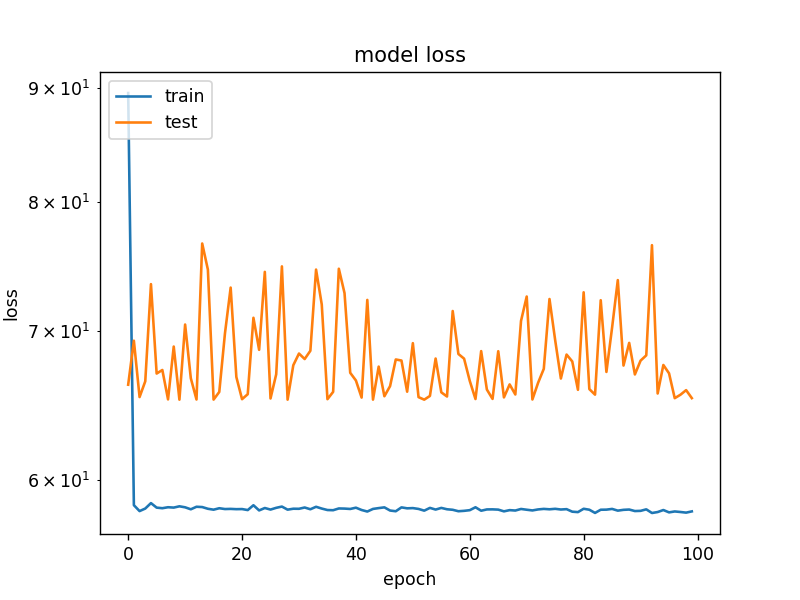

In [44]:
%matplotlib nbagg

print history.history['loss'][-1:]
print history.history['val_loss'][-1:]

print inputs[-25:]

print model.predict(inputs[-25:])
print outputs[-25:]

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()